# Dataset exploration

- Dataset summary: images, videos, annotations, coverage
- Class distribution and frames-per-video plots
- Random sample grid with drawn bounding boxes
- Per-video browser
- Basic integrity checks (missing labels, invalid label lines)
- Optional export of a derived CSV for use elsewhere

In [1]:
# Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
print('✓ Libraries imported')

✓ Libraries imported


## Configuration
Update these paths to match your annotated output directory (containing `images/` and `labels/`).

In [2]:
# Base project directory (used for relative pathing if desired)
BASE_DIR = Path(r'/home/detect/DeTect_TaiwanBirds_VideoDetector')

# Output directory produced by your annotation tool (contains images/ and labels/)
# Change this to your actual annotated output directory
OUTPUT_DIR = Path(r'/home/data/F2/videos/2025-05-14/')

IMAGES_DIR = OUTPUT_DIR / 'images'
LABELS_DIR = OUTPUT_DIR / 'labels'

print(f'Output dir: {OUTPUT_DIR}')
print(f'Images dir exists: {IMAGES_DIR.exists()}')
print(f'Labels dir exists: {LABELS_DIR.exists()}')

Output dir: /home/data/F2/videos/2025-05-14
Images dir exists: True
Labels dir exists: True


## Class Mapping
Loads `classes.csv` if available, otherwise falls back to a default mapping.

In [3]:
import csv

class_mapping = {}
classes_csv = OUTPUT_DIR / 'classes.csv'

if classes_csv.exists():
    with open(classes_csv, 'r', newline='') as f:
        reader = csv.reader(f)
        header = next(reader, None)
        for row in reader:
            if len(row) >= 2:
                class_id = int(row[0])
                class_name = row[1]
                class_mapping[class_id] = class_name
    print(f'✓ Loaded {len(class_mapping)} classes from {classes_csv}')
else:
    class_mapping = {0: 'Bat', 1: 'Bird', 2: 'Insect', 3: 'Drone', 4: 'Plane', 5: 'Other'}
    print('⚠ classes.csv not found, using default mapping:', class_mapping)

✓ Loaded 7 classes from /home/data/F2/videos/2025-05-14/classes.csv


## Helper Functions
Utilities to read YOLO annotations, draw bounding boxes, and parse video/frame info from filenames.

In [4]:
IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

def load_yolo_annotations(label_path: Path):
    bboxes = []  # list of (class_id, x_center, y_center, width, height) normalized [0,1]
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    try:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        bboxes.append((class_id, x_center, y_center, width, height))
                    except Exception:
                        # skip invalid line
                        pass
    return bboxes

def yolo_to_xyxy(xc, yc, w, h, img_h, img_w):
    x1 = int((xc - w/2) * img_w)
    y1 = int((yc - h/2) * img_h)
    x2 = int((xc + w/2) * img_w)
    y2 = int((yc + h/2) * img_h)
    return max(0, x1), max(0, y1), min(img_w, x2), min(img_h, y2)

def draw_bboxes(image_bgr, bboxes, class_colors=None, thickness=2):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    for bbox in bboxes:
        cid, xc, yc, bw, bh = bbox
        x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, bw, bh, h, w)
        color = (0, 255, 0) if class_colors is None else class_colors.get(cid, (0, 255, 0))
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        label = str(class_mapping.get(cid, f'Class {cid}'))
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x1, max(0, y1 - th - 4)), (x1 + tw, y1), color, -1)
        cv2.putText(img, label, (x1, max(1, y1 - 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    return img

def parse_video_and_frame(stem: str):
    # Assumes filename like 'videoName_00123'
    parts = stem.rsplit('_', 1)
    if len(parts) == 2:
        video_name = parts[0]
        try:
            frame_number = int(parts[1])
        except ValueError:
            video_name, frame_number = stem, -1
    else:
        video_name, frame_number = stem, -1
    return video_name, frame_number

def infer_video_path_from_image(image_path: Path):
    # Heuristic similar to dataset CSV generator in this repo
    s = str(image_path)
    s = s.replace('_videos_annotated\\images', '').replace('_videos_annotated/images', '')
    for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
        if s.endswith(ext):
            s = s[: -len(ext)] + '.mp4'
            break
    return s

## Build DataFrame from `images/` + `labels/`
Scans your annotated frames, extracts dimensions, per-frame annotations, and links frames to videos.

In [5]:
rows = []
if not IMAGES_DIR.exists():
    raise FileNotFoundError(f'Images directory not found: {IMAGES_DIR}')

image_files = [p for p in IMAGES_DIR.iterdir() if p.suffix in IMAGE_EXTS]
image_files.sort()
print(f'Found {len(image_files)} image(s)')

for i, img_path in enumerate(image_files, 1):
    label_path = LABELS_DIR / (img_path.stem + '.txt')
    bboxes = load_yolo_annotations(label_path)
    num_targets = len(bboxes)
    class_names = sorted({class_mapping.get(b[0], f'Unknown_{b[0]}') for b in bboxes}) if bboxes else []
    try:
        with Image.open(img_path) as im:
            w, h = im.size
            img_format = im.format
    except Exception as e:
        # Skip unreadable image
        print(f'Warning: cannot read {img_path.name}: {e}')
        continue

    video_name, frame_number = parse_video_and_frame(img_path.stem)
    video_path = infer_video_path_from_image(img_path)
    try:
        rel_img = img_path.relative_to(BASE_DIR)
    except Exception:
        rel_img = img_path

    rows.append({
        'image_path': str(rel_img),
        'image_full_path': str(img_path),
        'label_path': str(label_path),
        'image_width': w,
        'image_height': h,
        'image_format': img_format,
        'num_targets': num_targets,
        'classes': ';'.join(class_names) if class_names else 'Background',
        'has_annotations': 'Yes' if num_targets > 0 else 'No',
        'video_path': video_path,
        'video_name': video_name,
        'frame_number': frame_number
    })

    if i % 100 == 0:
        print(f'Processed {i}/{len(image_files)} images...')

df = pd.DataFrame(rows)
print('DataFrame shape:', df.shape)
df.head(5)

Found 21614 image(s)


Processed 100/21614 images...
Processed 200/21614 images...
Processed 300/21614 images...
Processed 400/21614 images...
Processed 500/21614 images...
Processed 600/21614 images...
Processed 700/21614 images...
Processed 800/21614 images...
Processed 900/21614 images...
Processed 1000/21614 images...
Processed 1100/21614 images...
Processed 1200/21614 images...
Processed 1300/21614 images...
Processed 1400/21614 images...
Processed 1500/21614 images...
Processed 1600/21614 images...
Processed 1700/21614 images...
Processed 1800/21614 images...
Processed 1900/21614 images...
Processed 2000/21614 images...
Processed 2100/21614 images...
Processed 2200/21614 images...
Processed 2300/21614 images...
Processed 2400/21614 images...
Processed 2500/21614 images...
Processed 2600/21614 images...
Processed 2700/21614 images...
Processed 2800/21614 images...
Processed 2900/21614 images...
Processed 3000/21614 images...
Processed 3100/21614 images...
Processed 3200/21614 images...
Processed 3300/21

,image_path,image_full_path,label_path,image_width,image_height,image_format,num_targets,classes,has_annotations,video_path,video_name,frame_number
0,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/labels/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,0
1,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/labels/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,124
2,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/labels/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,149
3,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/labels/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,16
4,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/images/A03_000...,/home/data/F2/videos/2025-05-14/labels/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,174


## Summary and Stats

In [6]:
print('='*60)
print('DATASET SUMMARY')
print('='*60)
print(f'Total images: {len(df)}')
print(f"Annotated images: {(df['has_annotations'] == 'Yes').sum()}")
print(f"Unannotated images: {(df['has_annotations'] == 'No').sum()}")

cov = ((df['has_annotations'] == 'Yes').sum() / len(df) * 100) if len(df) else 0
print(f'Annotation coverage: {cov:.1f}%')
print(f"Unique videos: {df['video_name'].nunique()}")
print(f"Unique classes strings: {df['classes'].nunique()}")
print()
print('Image dimensions:')
if len(df):
    print(f"  Width  - Min: {df['image_width'].min()}, Max: {df['image_width'].max()}, Mean: {df['image_width'].mean():.0f}")
    print(f"  Height - Min: {df['image_height'].min()}, Max: {df['image_height'].max()}, Mean: {df['image_height'].mean():.0f}")
print()
print('Object count stats:')
if len(df):
    total_targets = df['num_targets'].sum()
    mean_targets = df['num_targets'].mean()
    max_targets = df['num_targets'].max()
else:
    total_targets = 0
    mean_targets = 0
    max_targets = 0
print(f"  Total targets: {total_targets}")
print(f"  Mean targets/image: {mean_targets:.2f}")
print(f"  Max targets in single image: {max_targets}")

DATASET SUMMARY
Total images: 21614
Annotated images: 1637
Unannotated images: 19977
Annotation coverage: 7.6%
Unique videos: 2007
Unique classes strings: 10

Image dimensions:
  Width  - Min: 1920, Max: 1920, Mean: 1920
  Height - Min: 1080, Max: 1080, Mean: 1080

Object count stats:
  Total targets: 1965
  Mean targets/image: 0.09
  Max targets in single image: 7


## Per-Video Browser (Interactive)
Use the dropdown to select a video, then slide through frames. If `ipywidgets` is not installed, install it with `pip install ipywidgets`. 

In [7]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception as e:
    widgets = None
    print('ipywidgets not available. Install with: pip install ipywidgets')
    print('Error:', e)

images_by_video = defaultdict(list)
for _, r in df.sort_values(['video_name','frame_number']).iterrows():
    images_by_video[r['video_name']].append((r['image_full_path'], r['label_path'], r['frame_number']))

if widgets and len(images_by_video) > 0:
    video_options = sorted(images_by_video.keys())
    video_dd = widgets.Dropdown(options=video_options, description='Video:')
    idx_slider = widgets.IntSlider(value=0, min=0, max=max(0, len(images_by_video[video_options[0]])-1), step=1, description='Index:')

    out = widgets.Output()

    def update_idx_slider(*args):
        v = video_dd.value
        idx_slider.max = max(0, len(images_by_video[v]) - 1)
        idx_slider.value = 0

    def render(*args):
        v = video_dd.value
        idx = idx_slider.value
        img_path, lbl_path, frame_no = images_by_video[v][idx]
        
        with out:
            clear_output(wait=True)
            # Read image only once
            img = cv2.imread(img_path)
            if img is None:
                print(f'Failed to load {img_path}')
                return
            
            bboxes = load_yolo_annotations(Path(lbl_path))
            drawn = draw_bboxes(img, bboxes)
            
            # Use plt.subplots for better control and faster rendering
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
            ax.set_title(f'{Path(img_path).name} | Frame {frame_no} | {len(bboxes)} bbox(es)')
            ax.axis('off')
            plt.tight_layout()
            plt.show()
            plt.close(fig)  # Free memory

    video_dd.observe(update_idx_slider, names='value')
    video_dd.observe(render, names='value')
    idx_slider.observe(render, names='value')

    update_idx_slider()
    render()
    display(widgets.VBox([video_dd, idx_slider, out]))
else:
    print('Interactive browser unavailable (missing ipywidgets or empty dataset).')

ipywidgets not available. Install with: pip install ipywidgets
Error: No module named 'ipywidgets'


Interactive browser unavailable (missing ipywidgets or empty dataset).


## Random Sample Grid with Bounding Boxes

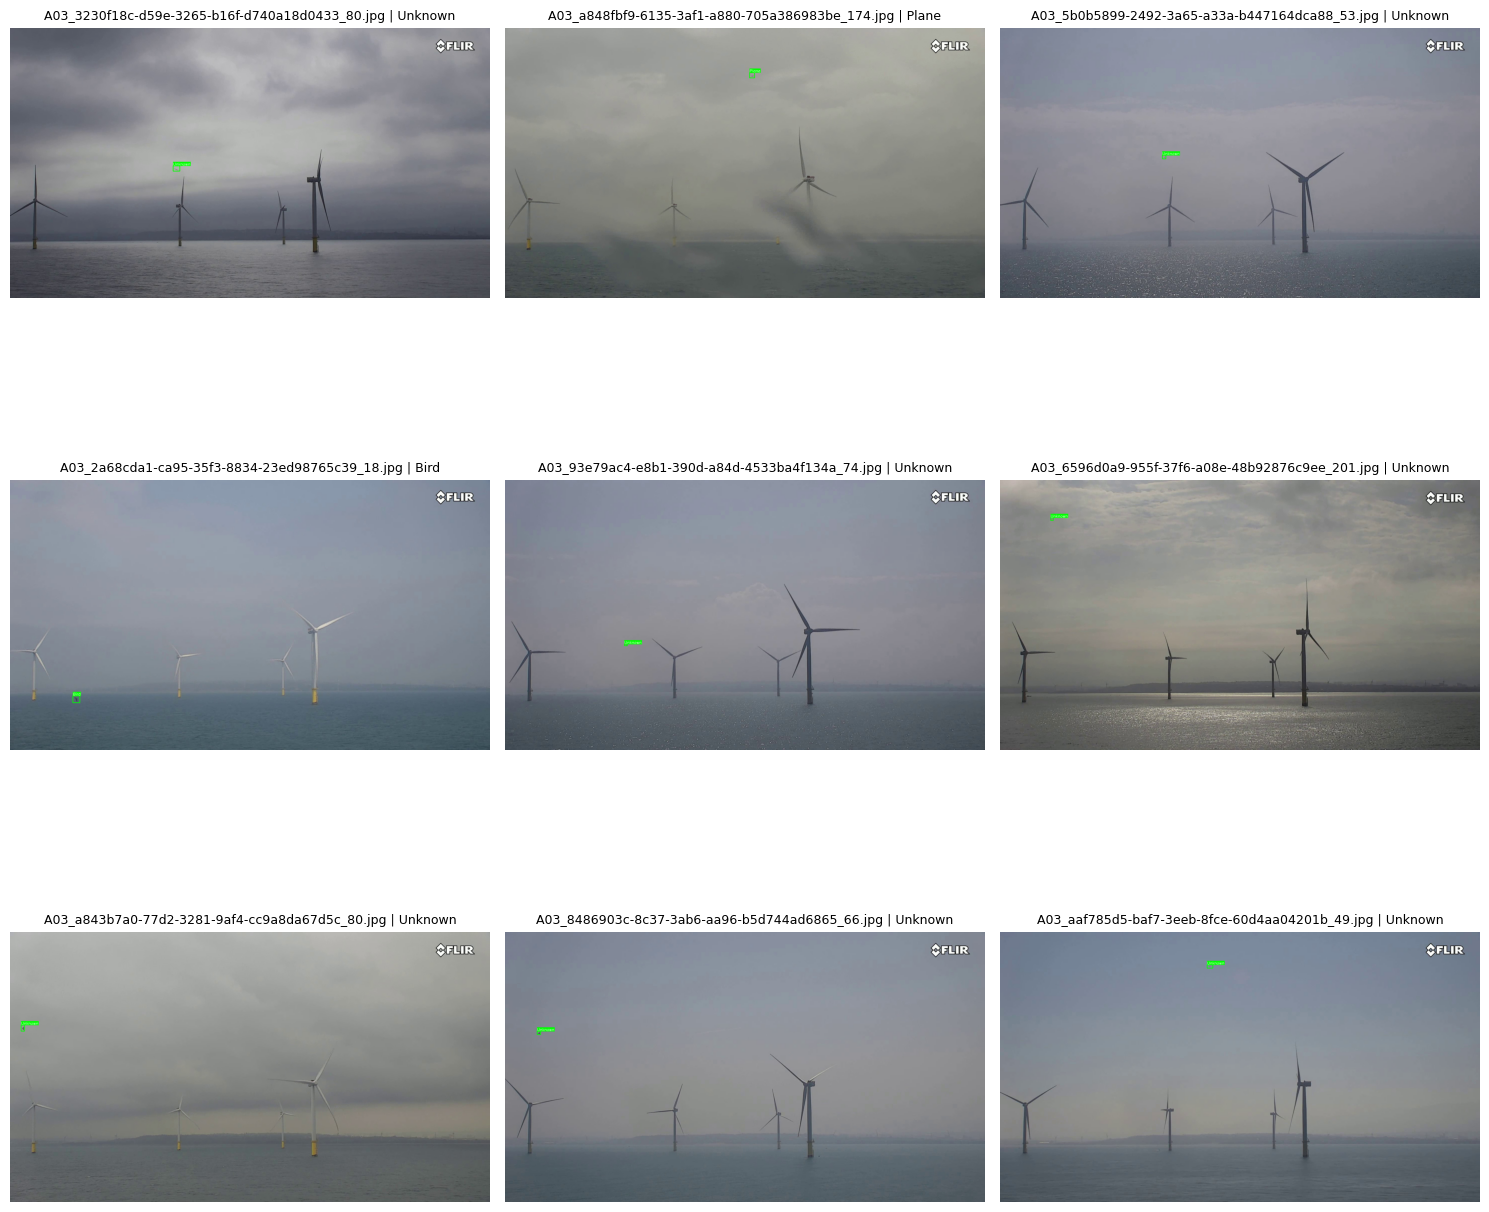

In [8]:
SAMPLE_COUNT = 9  # change to view more/less

# samples that are not background
samples = df[df['num_targets'] > 0].sample(min(SAMPLE_COUNT, len(df[df['num_targets'] > 0])), random_state=42) if len(df) else df
cols = 3
rows = int(np.ceil(len(samples) / cols)) if len(samples) else 0

if len(samples) == 0:
    print('No images found to visualize.')
else:
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.reshape(rows, cols)

    for idx, (_, row) in enumerate(samples.iterrows()):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        img = cv2.imread(row['image_full_path'])
        if img is None:
            ax.set_title('Failed to load image')
            ax.axis('off')
            continue
        bboxes = load_yolo_annotations(Path(row['label_path']))
        drawn = draw_bboxes(img, bboxes)
        ax.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        title = f"{Path(row['image_full_path']).name} | {row['classes']}"
        ax.set_title(title, fontsize=9)
        ax.axis('off')

    # Hide leftover axes
    for i in range(idx+1, rows*cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

## Plots: Class Distribution and Frames per Video

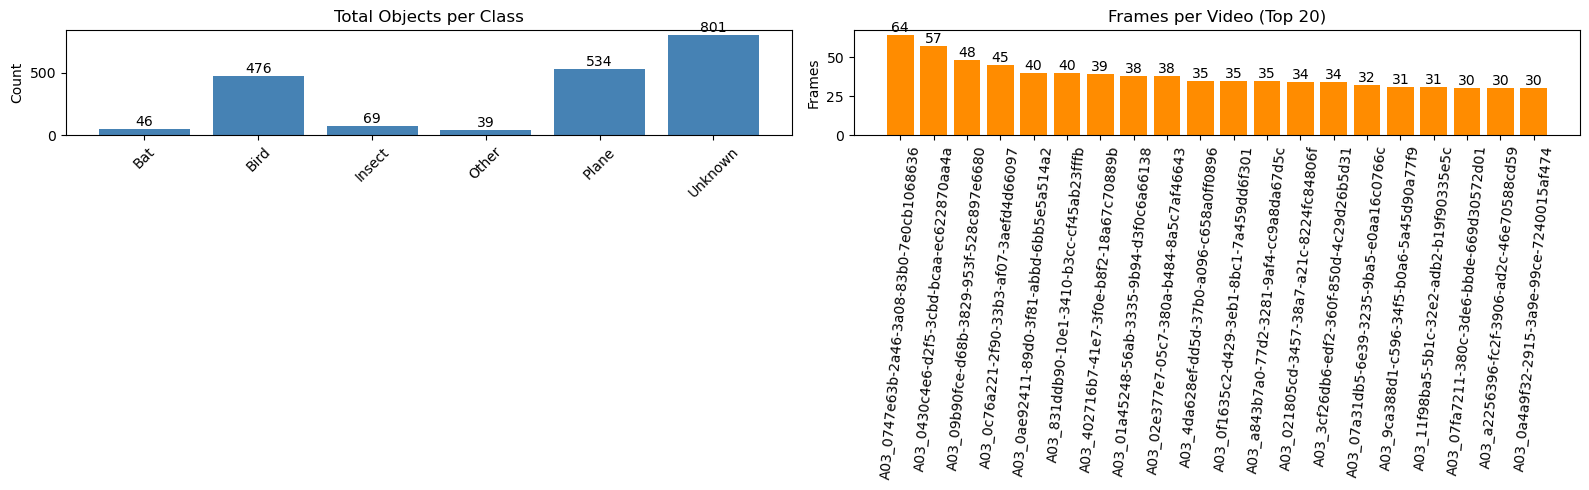

In [9]:
# Aggregate classes across objects and frames per video
from collections import defaultdict

class_counts = defaultdict(int)
images_with_class = defaultdict(int)

for _, row in df.iterrows():
    classes_str = row['classes']
    if classes_str and classes_str != 'Background':
        for name in classes_str.split(';'):
            images_with_class[name] += 1
    # count total objects per class from label file
    if row['num_targets'] > 0 and os.path.exists(row['label_path']):
        with open(row['label_path'], 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1:
                    try:
                        cid = int(parts[0])
                        cname = class_mapping.get(cid, f'Unknown_{cid}')
                        class_counts[cname] += 1
                    except Exception:
                        pass

frames_per_video = df.groupby('video_name')['image_path'].count().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Left: class distribution
cls_names = list(sorted(class_counts.keys()))
cls_vals = [class_counts[k] for k in cls_names]
axes[0].bar(cls_names, cls_vals, color='steelblue')
axes[0].set_title('Total Objects per Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(cls_vals):
    if v > 0:
        axes[0].text(i, v, str(v), ha='center', va='bottom')

# Right: top videos by number of frames
topk = frames_per_video.head(20)
axes[1].bar(topk.index.astype(str), topk.values, color='darkorange')
axes[1].set_title('Frames per Video (Top 20)')
axes[1].set_ylabel('Frames')
axes[1].tick_params(axis='x', rotation=85)
for i, v in enumerate(topk.values):
    axes[1].text(i, v, str(int(v)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

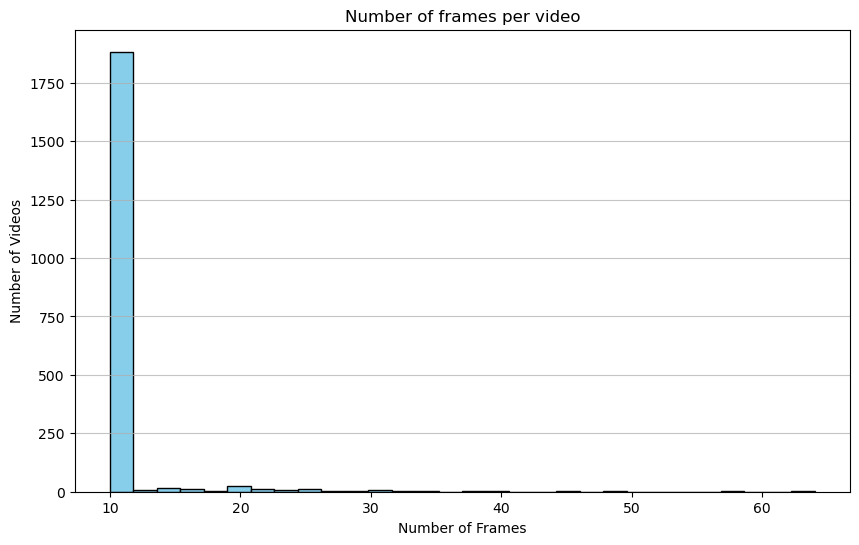

In [10]:
# figure of histogram of number of frames per video
fig = plt.figure(figsize=(10,6))
plt.hist(frames_per_video.values, bins=30, color='skyblue', edgecolor='black')
plt.title(f'Number of frames per video')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.grid(axis='y', alpha=0.75)
plt.show()

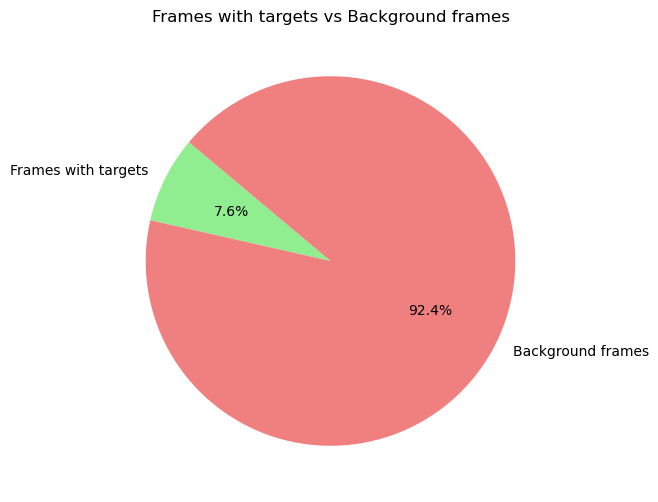

In [11]:
# Number of frames with a label and without a label
labeled_frames = (df['num_targets'] > 0).sum()
unlabeled_frames = (df['num_targets'] == 0).sum()

fig = plt.figure(figsize=(6,6))
labels = ['Frames with targets', 'Background frames']
sizes = [labeled_frames, unlabeled_frames]
colors = ['lightgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Frames with targets vs Background frames')
plt.show()


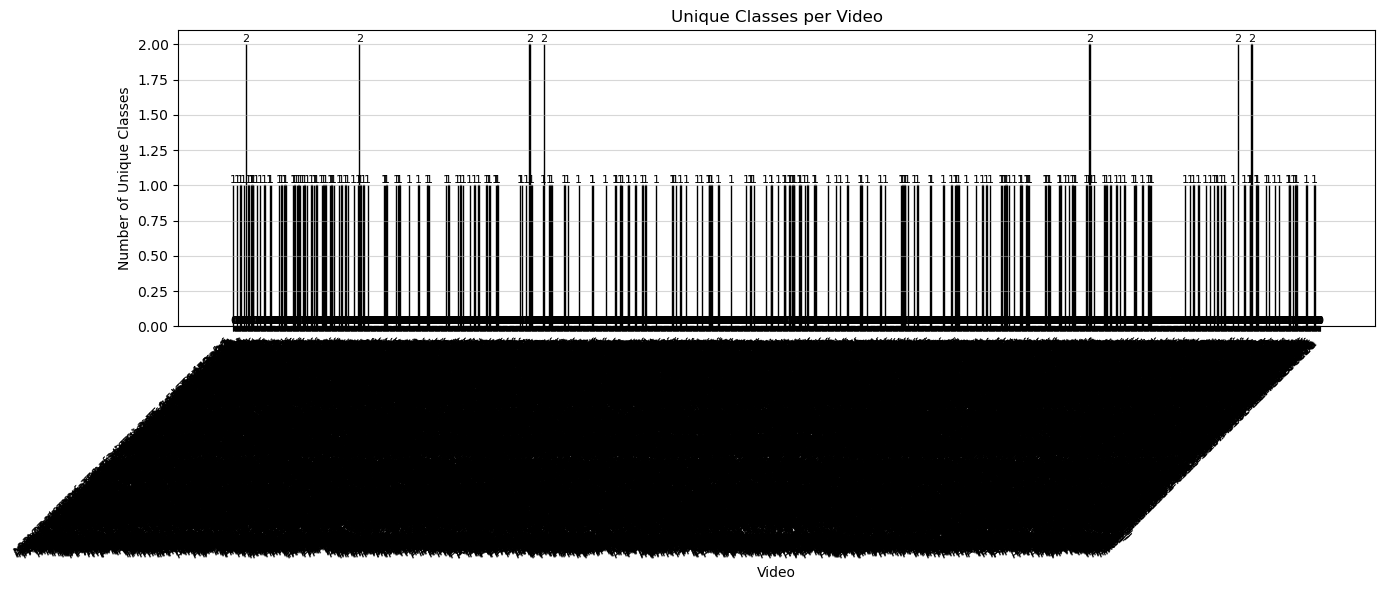

In [12]:
## Class Presence per Video Heatmap - Visualizes which classes appear in each video. Each row is a video, each column is a class. Green = class present, gray = not present.

# Summary: class count per video
class_per_video_count = []
videos = df['video_name'].unique()
video_names_list = sorted(videos)

for video in sorted(videos):
    video_df = df[df['video_name'] == video]
    classes_in_video = set()
    for _, row in video_df.iterrows():
        if row['num_targets'] > 0 and row['classes'] and row['classes'] != 'Background':
            for cls in row['classes'].split(';'):
                classes_in_video.add(cls)
    
    num_classes = len(classes_in_video) if classes_in_video else 0
    class_per_video_count.append(num_classes)

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(len(video_names_list)), class_per_video_count, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(video_names_list)))
ax.set_xticklabels(video_names_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Number of Unique Classes')
ax.set_xlabel('Video')
ax.set_title('Unique Classes per Video')
ax.grid(axis='y', alpha=0.5)

# Add value labels on bars
for i, v in enumerate(class_per_video_count):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [13]:
# import matplotlib.patches as mpatches

# # Build class presence matrix per video
# videos = df['video_name'].unique()
# all_classes_in_df = set()

# # Collect all unique classes across all frames
# for _, row in df.iterrows():
#     if row['classes'] and row['classes'] != 'Background':
#         for cls in row['classes'].split(';'):
#             all_classes_in_df.add(cls)

# # If no classes found, use default
# if not all_classes_in_df:
#     all_classes_in_df = set(class_mapping.values())

# all_classes_sorted = sorted(list(all_classes_in_df))

# # Create presence matrix: 1 if class present in video, 0 otherwise
# presence_matrix = []
# video_names_list = []

# for video in sorted(videos):
#     video_df = df[df['video_name'] == video]
#     presence_row = []
    
#     # Check which classes appear in this video
#     classes_in_video = set()
#     for _, row in video_df.iterrows():
#         if row['num_targets'] > 0 and row['classes'] and row['classes'] != 'Background':
#             for cls in row['classes'].split(';'):
#                 classes_in_video.add(cls)
    
#     # Build presence vector
#     for cls in all_classes_sorted:
#         presence_row.append(1 if cls in classes_in_video else 0)
    
#     presence_matrix.append(presence_row)
#     video_names_list.append(video)

# # Convert to numpy array for easier heatmap visualization
# presence_array = np.array(presence_matrix)

# # Create heatmap
# fig, ax = plt.subplots(figsize=(12, max(6, len(video_names_list) * 0.3)))
# im = ax.imshow(presence_array, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# # Set ticks and labels
# ax.set_xticks(np.arange(len(all_classes_sorted)))
# ax.set_yticks(np.arange(len(video_names_list)))
# ax.set_xticklabels(all_classes_sorted, rotation=45, ha='right')
# ax.set_yticklabels(video_names_list, fontsize=8)

# # Add text annotations
# for i in range(len(video_names_list)):
#     for j in range(len(all_classes_sorted)):
#         if presence_array[i, j] == 1:
#             text = ax.text(j, i, '✓', ha="center", va="center", color="black", fontsize=10, weight='bold')

# ax.set_title('Class Presence per Video')
# ax.set_xlabel('Class')
# ax.set_ylabel('Video')

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Present (1) / Absent (0)', rotation=270, labelpad=15)

# plt.tight_layout()
# plt.show()

# print(f'Total videos: {len(video_names_list)}')
# print(f'Total unique classes: {len(all_classes_sorted)}')


## Total Objects per Video
Bar plot showing the total count of annotated objects in each video.

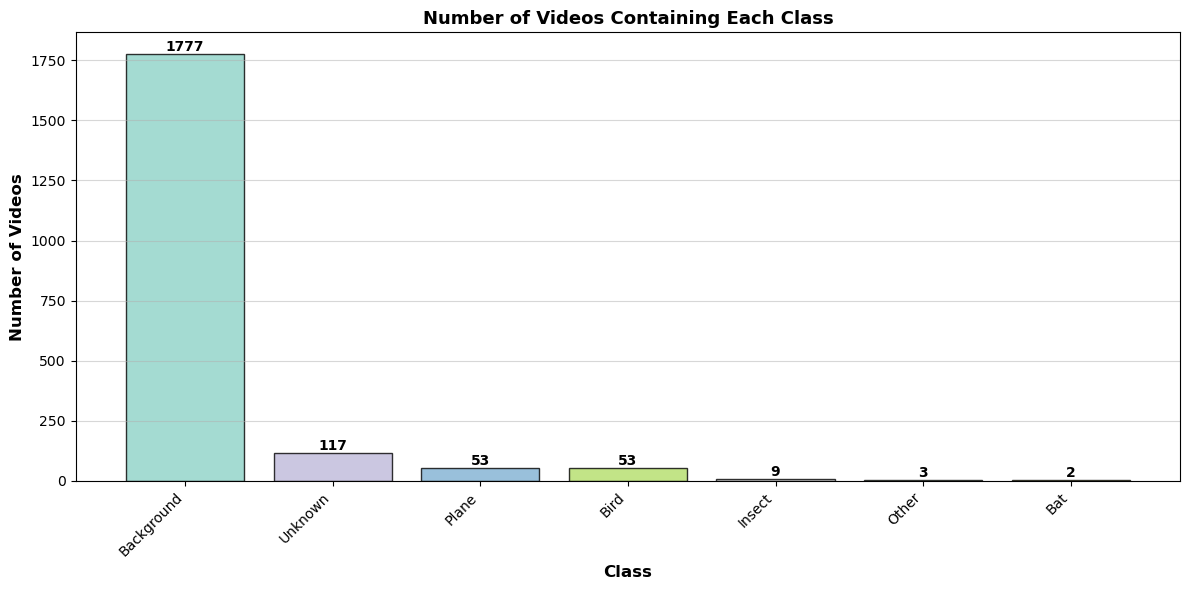

Videos per Class:
----------------------------------------
  Background     : 1777 videos ( 88.5%)
  Unknown        : 117 videos (  5.8%)
  Plane          :  53 videos (  2.6%)
  Bird           :  53 videos (  2.6%)
  Insect         :   9 videos (  0.4%)
  Other          :   3 videos (  0.1%)
  Bat            :   2 videos (  0.1%)
----------------------------------------
Total videos: 2007


In [14]:
# Count videos per class (x-axis: classes, y-axis: number of videos containing that class)
videos_per_class = defaultdict(int)

# Get unique videos
all_videos = df['video_name'].unique()

for video in all_videos:
    video_df = df[df['video_name'] == video]
    classes_in_video = set()
    
    # Check which classes appear in this video
    for _, row in video_df.iterrows():
        if row['num_targets'] > 0 and row['classes'] and row['classes'] != 'Background':
            for cls in row['classes'].split(';'):
                classes_in_video.add(cls)
    
    # If video has classes, add 1 to each class count
    if classes_in_video:
        for cls in classes_in_video:
            videos_per_class[cls] += 1
    else:
        # If no classes found, count as background
        videos_per_class['Background'] += 1

# Sort by count
videos_per_class_sorted = dict(sorted(videos_per_class.items(), key=lambda x: x[1], reverse=True))

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))
class_names = list(videos_per_class_sorted.keys())
class_counts = list(videos_per_class_sorted.values())

colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
bars = ax.bar(class_names, class_counts, color=colors, edgecolor='black', alpha=0.8)

ax.set_ylabel('Number of Videos', fontsize=12, fontweight='bold')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_title('Number of Videos Containing Each Class', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.5)

# Add value labels on bars
for i, v in enumerate(class_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary
print('Videos per Class:')
print('-' * 40)
for cls, count in videos_per_class_sorted.items():
    pct = (count / len(all_videos)) * 100
    print(f'  {cls:15s}: {count:3d} videos ({pct:5.1f}%)')
print('-' * 40)
print(f'Total videos: {len(all_videos)}')
